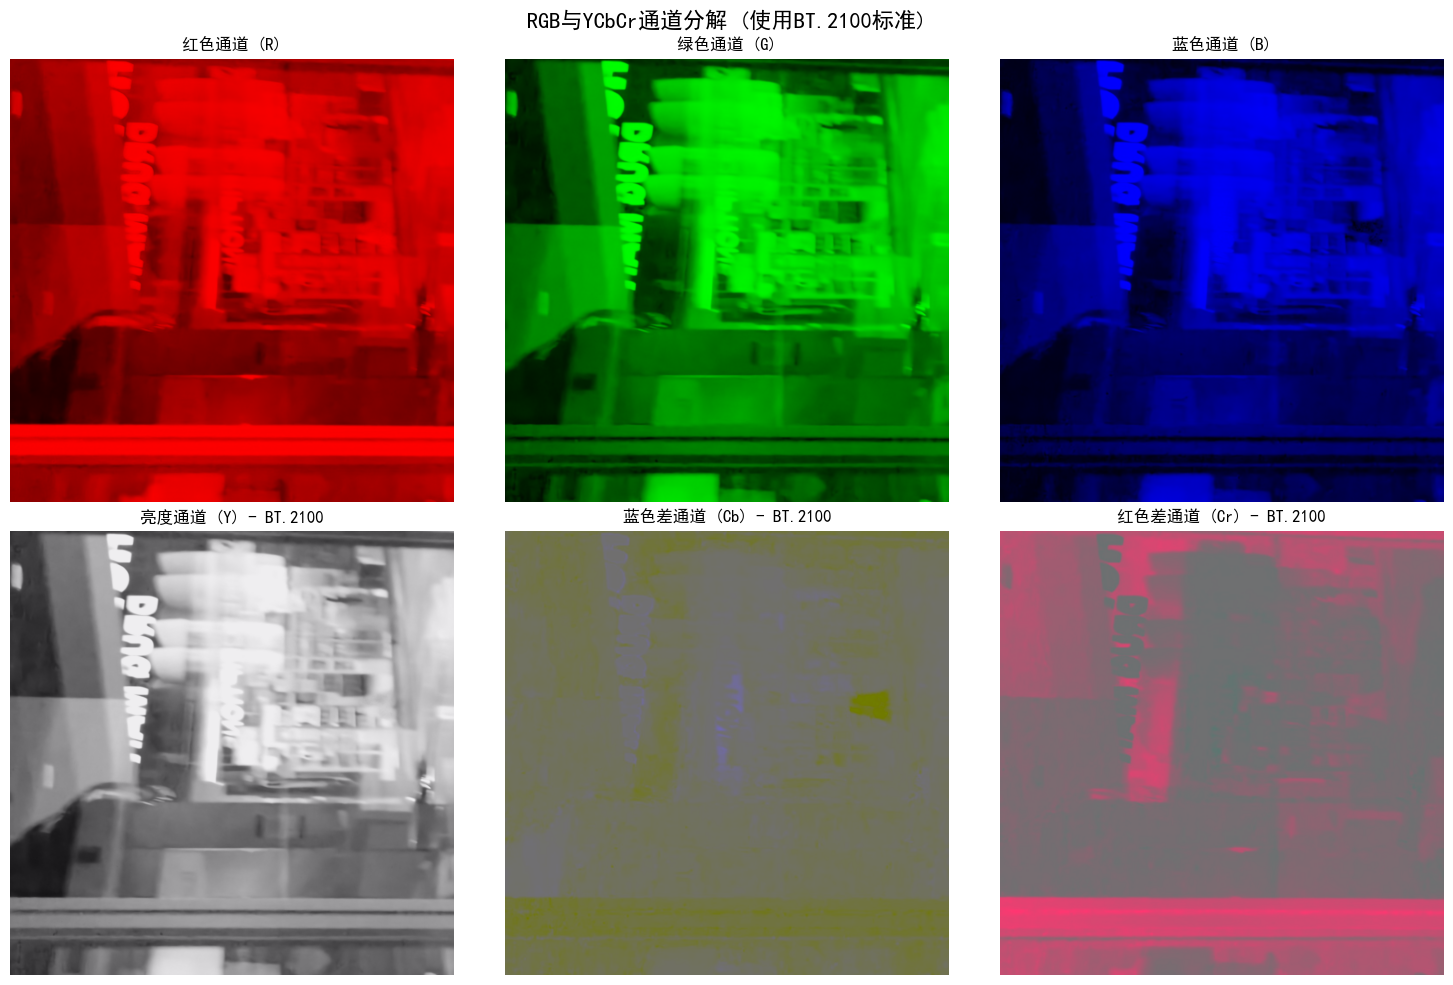

处理完成！已使用BT.2100标准生成RGB和YCbCr各通道图像


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # Use SimHei font
plt.rcParams['axes.unicode_minus'] = False    # Fix minus sign display issue

# Read input image
image = cv2.imread('../2/input2.png')

if image is None:
    print("Error: Unable to read image. Please check file path")
    exit()

# Convert BGR to RGB (OpenCV reads as BGR by default)
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Separate RGB channels
r_channel = rgb_image.copy()
r_channel[:, :, 1] = 0  # Set G channel to 0
r_channel[:, :, 2] = 0  # Set B channel to 0

g_channel = rgb_image.copy()
g_channel[:, :, 0] = 0  # Set R channel to 0
g_channel[:, :, 2] = 0  # Set B channel to 0

b_channel = rgb_image.copy()
b_channel[:, :, 0] = 0  # Set R channel to 0
b_channel[:, :, 1] = 0  # Set G channel to 0

# Define BT.2100 conversion matrix (RGB to YCbCr)
# Note: OpenCV uses BT.601 by default, here we manually implement BT.2100 conversion
def rgb_to_ycbcr_bt2100(rgb_img):
    # BT.2100 conversion matrix (RGB to YCbCr)
    transform_matrix = np.array([
        [0.2627, 0.6780, 0.0593],    # Y coefficients
        [-0.1396, -0.3604, 0.5000],  # Cb coefficients
        [0.5000, -0.4598, -0.0402]   # Cr coefficients
    ])
    
    # Convert image to float and normalize
    img_float = rgb_img.astype(np.float32) / 255.0
    
    # Reshape image to 2D array (height*width, channels)
    h, w, c = img_float.shape
    img_reshaped = img_float.reshape(-1, 3)
    
    # Apply transformation matrix
    ycbcr_reshaped = np.dot(img_reshaped, transform_matrix.T)
    
    # Add offsets
    ycbcr_reshaped[:, 0] += 0.0625  # Y offset (16/256)
    ycbcr_reshaped[:, 1] += 0.5     # Cb offset (128/256)
    ycbcr_reshaped[:, 2] += 0.5     # Cr offset (128/256)
    
    # Clip values to 0-1 range
    ycbcr_reshaped = np.clip(ycbcr_reshaped, 0, 1)
    
    # Reshape back to image shape and convert to 8-bit
    ycbcr_img = (ycbcr_reshaped.reshape(h, w, c) * 255).astype(np.uint8)
    
    return ycbcr_img

def ycbcr_to_rgb_bt2100(ycbcr_img):
    # BT.2100 inverse conversion matrix (YCbCr to RGB)
    inverse_matrix = np.array([
        [1.0, 0.0, 1.4746],         # R coefficients
        [1.0, -0.1646, -0.5714],     # G coefficients
        [1.0, 1.8814, 0.0]           # B coefficients
    ])
    
    # Convert image to float and normalize
    img_float = ycbcr_img.astype(np.float32) / 255.0
    
    # Subtract offsets
    img_float[:, :, 0] -= 0.0625  # Y offset
    img_float[:, :, 1] -= 0.5      # Cb offset
    img_float[:, :, 2] -= 0.5      # Cr offset
    
    # Reshape image to 2D array (height*width, channels)
    h, w, c = img_float.shape
    img_reshaped = img_float.reshape(-1, 3)
    
    # Apply inverse transformation matrix
    rgb_reshaped = np.dot(img_reshaped, inverse_matrix.T)
    
    # Clip values to 0-1 range
    rgb_reshaped = np.clip(rgb_reshaped, 0, 1)
    
    # Reshape back to image shape and convert to 8-bit
    rgb_img = (rgb_reshaped.reshape(h, w, c) * 255).astype(np.uint8)
    
    return rgb_img

# Convert to YCbCr color space using BT.2100 standard
ycbcr_image = rgb_to_ycbcr_bt2100(rgb_image)

# Separate YCbCr channels
y_channel = ycbcr_image.copy()
y_channel[:, :, 1] = 128  # Set Cb to median value (gray)
y_channel[:, :, 2] = 128  # Set Cr to median value (gray)

cb_channel = ycbcr_image.copy()
cb_channel[:, :, 0] = 128  # Set Y to median value (gray)
cb_channel[:, :, 2] = 128  # Set Cr to median value (gray)

cr_channel = ycbcr_image.copy()
cr_channel[:, :, 0] = 128  # Set Y to median value (gray)
cr_channel[:, :, 1] = 128  # Set Cb to median value (gray)

# Create 2x3 subplot layout
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('RGB and YCbCr Channel Decomposition (BT.2100 Standard)', fontsize=16)

# Display RGB channels
axes[0, 0].imshow(r_channel)
axes[0, 0].set_title('Red Channel (R)')
axes[0, 0].axis('off')

axes[0, 1].imshow(g_channel)
axes[0, 1].set_title('Green Channel (G)')
axes[0, 1].axis('off')

axes[0, 2].imshow(b_channel)
axes[0, 2].set_title('Blue Channel (B)')
axes[0, 2].axis('off')

# Display YCbCr channels (using BT.2100 inverse conversion)
axes[1, 0].imshow(ycbcr_to_rgb_bt2100(y_channel))
axes[1, 0].set_title('Luminance Channel (Y) - BT.2100')
axes[1, 0].axis('off')

axes[1, 1].imshow(ycbcr_to_rgb_bt2100(cb_channel))
axes[1, 1].set_title('Blue-difference Channel (Cb) - BT.2100')
axes[1, 1].axis('off')

axes[1, 2].imshow(ycbcr_to_rgb_bt2100(cr_channel))
axes[1, 2].set_title('Red-difference Channel (Cr) - BT.2100')
axes[1, 2].axis('off')

# Adjust layout and save results
plt.tight_layout()
# plt.savefig('channel_decomposition_bt2100.jpg', dpi=300, bbox_inches='tight')
plt.show()

# Save each channel separately (using BT.2100 inverse conversion)
# cv2.imwrite('R_channel.jpg', cv2.cvtColor(r_channel, cv2.COLOR_RGB2BGR))
# cv2.imwrite('G_channel.jpg', cv2.cvtColor(g_channel, cv2.COLOR_RGB2BGR))
# cv2.imwrite('B_channel.jpg', cv2.cvtColor(b_channel, cv2.COLOR_RGB2BGR))
# cv2.imwrite('Y_channel_bt2100.jpg', cv2.cvtColor(ycbcr_to_rgb_bt2100(y_channel), cv2.COLOR_RGB2BGR))
# cv2.imwrite('Cb_channel_bt2100.jpg', cv2.cvtColor(ycbcr_to_rgb_bt2100(cb_channel), cv2.COLOR_RGB2BGR))
# cv2.imwrite('Cr_channel_bt2100.jpg', cv2.cvtColor(ycbcr_to_rgb_bt2100(cr_channel), cv2.COLOR_RGB2BGR))

print("Processing completed! Generated RGB and YCbCr channel images using BT.2100 standard")

In [10]:
import cv2
import numpy as np

def add_gaussian_noise(image, mean=0, sigma=25):
    """
    为图像添加高斯噪声
    :param image: 输入图像（OpenCV格式，BGR或灰度）
    :param mean: 噪声均值（默认0）
    :param sigma: 噪声标准差（默认25）
    :return: 带噪声的图像
    """
    # 将图像转换为浮点型并归一化到[0, 1]
    image = image.astype(np.float32) / 255.0
    
    # 生成高斯噪声（与图像同形状）
    noise = np.random.normal(mean, sigma/255.0, image.shape)
    
    # 叠加噪声并裁剪到[0, 1]范围
    noisy_image = image + noise
    noisy_image = np.clip(noisy_image, 0, 1)
    
    # 转换回[0, 255]范围并转为uint8
    noisy_image = (noisy_image * 255).astype(np.uint8)
    return noisy_image

# 示例用法
image = cv2.imread('input2.png', cv2.IMREAD_COLOR)  # 读取彩色图像
noisy_image = add_gaussian_noise(image, sigma=100)   # 添加噪声（标准差=30）
cv2.imwrite('noisy_image.jpg', noisy_image)         # 保存结果

True

In [26]:
import cv2
import numpy as np

def add_salt_pepper_noise(image, prob=0.002):
    """
    给图像添加椒盐噪声
    :param image: 输入图像 (numpy array)
    :param prob: 噪声比例 (0~1)，即有多少比例的像素会被替换
    :return: 添加噪声后的图像
    """
    output = np.copy(image)
    # 生成 [0,1) 的随机矩阵
    rnd = np.random.rand(*image.shape[:2])
    
    # 椒噪声（黑点）
    output[rnd < (prob / 2)] = 0
    
    # 盐噪声（白点）
    output[rnd > 1 - (prob / 2)] = 255
    
    return output

# 读取图像
img = cv2.imread("input2.jpg")
noisy_img = add_salt_pepper_noise(img, prob=0.01)

# 保存/展示
cv2.imwrite("Salt_and_Pepper_noisy.jpg", noisy_img)


True